<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/FCG_2_CND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up environment:

In [1]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100

batch_size = 16
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 5

img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels
#sparse_dim = 10
optimizer = Adam(0.0002, 0.5)

Using TensorFlow backend.


importing the data set:

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector

np.random.shuffle(x_train)
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)


Build FC generator CN discriminator with reconstructor:

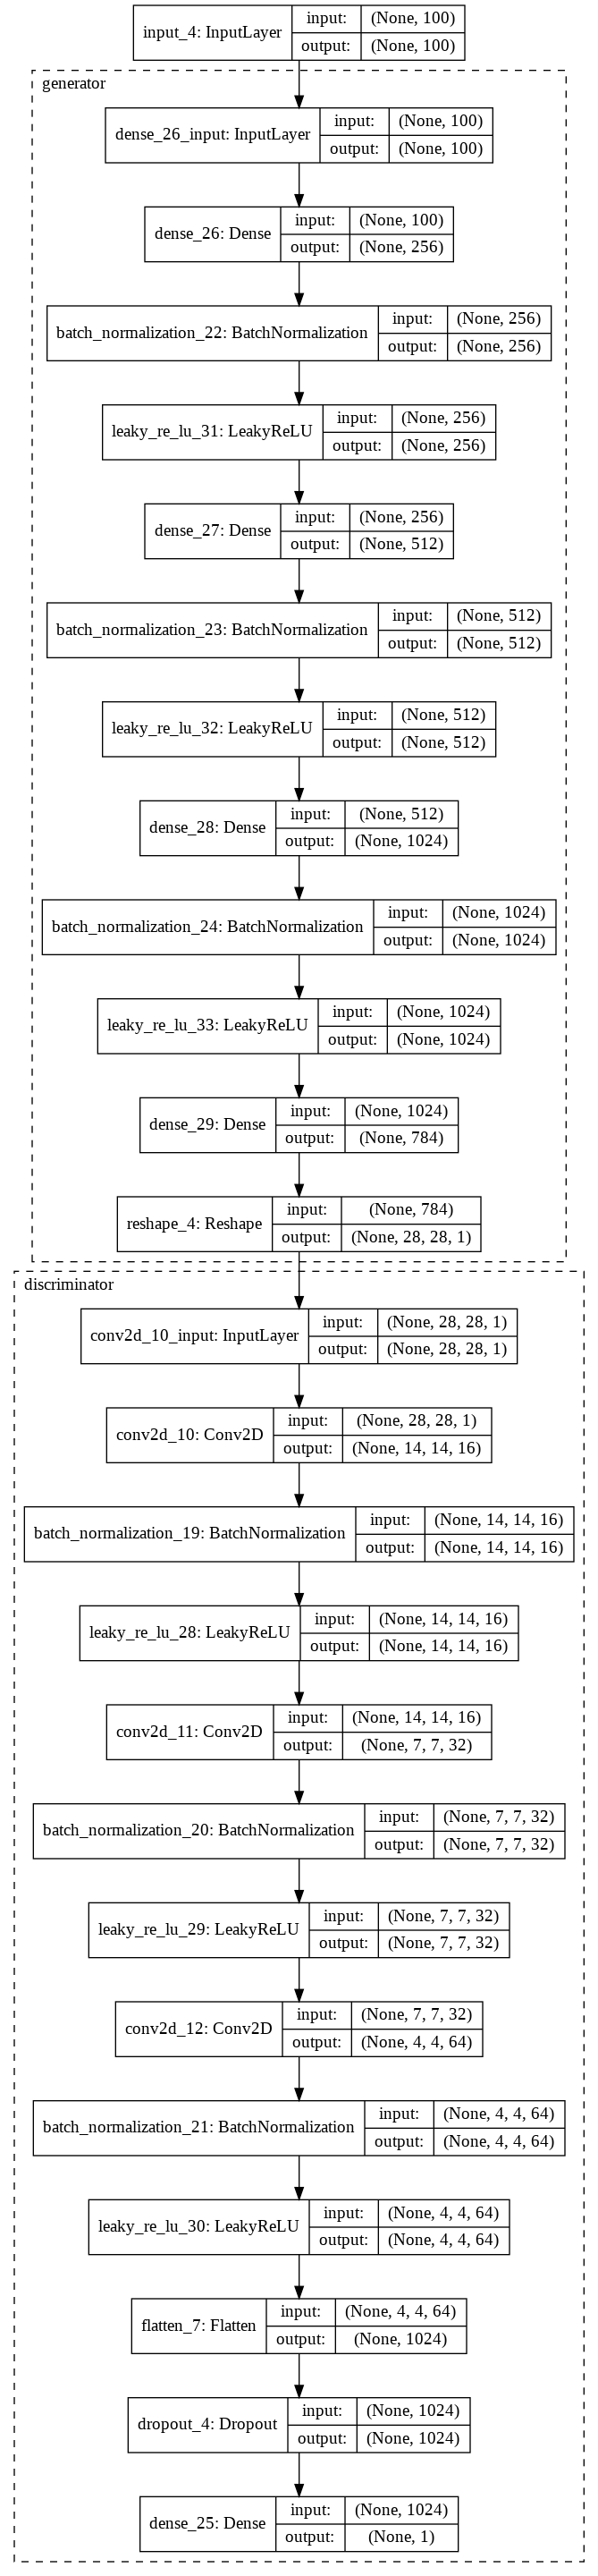

In [6]:
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization
from keras.utils import plot_model

# input: image size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: image size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    # remove this to return to FC scheme
    generator.add(Reshape((img_rows, img_cols, channels)))
    #generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
    
# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()
discriminator.name = "discriminator"
generator.name= "generator"
discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

fake_image_vec = Flatten()(fake_image)  # will enter reconstructor


gan_output = discriminator(fake_image)

vae_output = reconstructor(fake_image_vec)

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd') #todo: consider MAE


gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

plot_model(gan, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


Train the GAN model:

In [0]:
import matplotlib.pyplot as plt


for epoch in range(epochs):  
    for batch in range(steps_per_epoch): 
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:-1], disc_y[batch_size:-1])
        # train GAN (descriminator weights are fixed)
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        # train reconstructor
        r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

        

    print(f'Epoch: {epoch} \t Discriminator Loss: {(d_loss_fake+d_loss_real)/2} \t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} ')


def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
